# **Core Stock Baseline Modeling - Linear Regression for NVDA Ticker**
## In this notebook we will examine only the Nvidia stock for the periods we have selected for this project (03-14-2019 through 08-15-2024), and perform a Linear Regression model using the preprocessed dataframe that we created in our other notebook.  We will look to get an idea of how well our data is predicting with our new features that we created.

#### As usual let's start by bringing in our important libraries and logic for needing to complete this notebook.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

#### Now let's read in our data that we will use for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_preprocessed.csv')
preprocessed_df = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
preprocessed_df.head()

,Close_core,Volume_core,Open_core,High_core,Low_core,SMA_core,EMA_core,RSI_core,BBM_core,BBU_core,...,Momentum_7_Lag_Std_1_3_core,Momentum_30_Lag_Avg_1_3_core,Momentum_30_Lag_Std_1_3_core,Momentum_50_Lag_Avg_1_3_core,Momentum_50_Lag_Std_1_3_core,OBV_Lag_Avg_1_3_core,OBV_Lag_Std_1_3_core,Diff_Close_EMA_core,Ratio_Close_EMA_core,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-14,-0.954785,0.728372,-0.953290,-0.966273,-0.946685,-1.036480,-1.018443,1.079385,-1.036480,-1.032897,...,-0.960312,0.266059,-1.369997,0.346980,-1.656320,0.342800,0.990065,0.285847,0.791453,AAPL
2019-03-15,-0.941600,1.089768,-0.948034,-0.948515,-0.940119,-1.033031,-1.014385,1.123886,-1.033031,-1.026146,...,-0.960312,0.266059,-1.369997,0.346980,-1.656320,0.342800,0.990065,0.359522,0.904749,AAPL
2019-03-18,-0.931235,0.804435,-0.942805,-0.942752,-0.928810,-1.027449,-1.010056,1.184881,-1.027449,-1.022413,...,-0.960312,0.285578,-1.369997,0.346980,-1.656320,0.350356,0.990065,0.406600,0.979814,AAPL
2019-03-19,-0.939354,0.939245,-0.928897,-0.939505,-0.928097,-1.022811,-1.006262,0.998369,-1.022811,-1.018185,...,-0.706927,0.311034,-1.186987,0.462064,0.146955,0.356017,1.111171,0.319406,0.831117,AAPL
2019-03-20,-0.930476,0.925268,-0.940447,-0.936806,-0.934642,-1.017958,-1.002250,1.242326,-1.017958,-1.013869,...,-1.061720,0.277183,-0.812932,0.520063,0.006155,0.360051,0.648621,0.359608,0.891442,AAPL


#### Great now let's grab the data just for our subject NVDA ticker to use in our Linear Regression model.

In [3]:
nvda_data = preprocessed_df[preprocessed_df['Ticker'] == 'NVDA']
print(nvda_data.head())
nvda_data.shape

            Close_core  Volume_core  Open_core  High_core  Low_core  SMA_core  \
Date                                                                            
2019-03-14   -3.260108     1.950963  -3.242019  -3.255656 -3.245005 -3.303807   
2019-03-15   -3.238778     2.124280  -3.250480  -3.245449 -3.235360 -3.300157   
2019-03-18   -3.243059     1.904813  -3.231649  -3.237002 -3.231847 -3.295723   
2019-03-19   -3.209874     2.308161  -3.223387  -3.216420 -3.210917 -3.291463   
2019-03-20   -3.216223     2.184179  -3.203400  -3.209108 -3.206410 -3.288134   

            EMA_core  RSI_core  BBM_core  BBU_core  ...  \
Date                                                ...   
2019-03-14 -3.305691  0.376196 -3.303807 -3.357026  ...   
2019-03-15 -3.301799  0.599224 -3.300157 -3.352045  ...   
2019-03-18 -3.298255  0.647997 -3.295723 -3.351209  ...   
2019-03-19 -3.293438  0.953098 -3.291463 -3.344050  ...   
2019-03-20 -3.289106  0.943516 -3.288134 -3.336977  ...   

            Moment

(1365, 153)

#### Now let's prepare our Linear Regression model.  We will be dropping the Ticker and Close columns for the X as Ticker is an improper format and our Close feature will be our y target.  The Date feature is our index so it won't be included in the model as it will automatically be excluded from the feature set.

In [4]:
X = nvda_data[['ATR_14_core_Lag_3', 'Momentum_1_Lag_Std_1_3_core', 'Open_Lag_Std_1_3_core', 'Momentum_30_Lag_Std_1_3_core', 'Momentum_50_Lag_Std_1_3_core',
                'Low_Lag_Std_1_3_core', 'High_Lag_Std_1_3_core', 'EMA_Lag_Std_1_3_core', 'MACD_Hist_Lag_Std_1_3_core', 'OBV_core', 'MACD_Lag_Std_1_3_core',
                'ATR_14_Lag_Std_1_3_core', 'MACD_Signal_Lag_Std_1_3_core', 'OBV_core_Lag_3', 'Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_3', 'Diff_Close_EMA_core',
                'BBU_Lag_Std_1_3_core', 'BBL_Lag_Std_1_3_core', 'Volume_Lag_Std_1_3_core', 'Momentum_7_core_Lag_3', 'Momentum_3_Lag_Avg_1_3_core', 'MACD_Hist_core_Lag_3',
                'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3'
                ]]
X = nvda_data.drop(columns = ['Close_core', 'Ticker'])
y = nvda_data['Close_core']
type(X), type(y), X.shape, y.shape

(pandas.core.frame.DataFrame, pandas.core.series.Series, (1365, 151), (1365,))

#### Let's now set up the rest of the model and run our first set of predictions on it.  I will be looking for the RMSE (Root Mean Squared Error) and the MAPE (Mean Absolute Percentage Error) for metrics here.  Since we also have over 150 features in our dataframe (due to the combination of our lag windows and our technical indictors we created) we will combine our Linear Regression with Ridge to select which features are best and needed as we move forward.  We will also use GridSearchCV on top of Ridge for hyperparameter tuning and optimization.

In [5]:
# Set up your train/test/split data using a manual split for time series
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

#### Now we need to set up the model with Ridge; this regularizes all features and rather than eliminate the features that don't contribute much (or at all), Ridge allows those features to still contribute to the model as opposed to Lasso.

In [6]:
# Define the Ridge model and set up the parameter grid. 
ridge = Ridge(max_iter = 10000)
param_grid = {'alpha' : np.logspace(-3, 3, 100)} # np.logspace from numpy generates numbers that are evenly spaced on a logarithmic scale.

#### Let's set up our GridSearchCV with TimeSeriesSplit.

In [7]:
tscv = TimeSeriesSplit(n_splits = 5)

grid_search = GridSearchCV(ridge,
                    param_grid,
                    cv = tscv,
                    scoring = 'neg_mean_squared_error',
                    n_jobs = -1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

#### Now let's extract the best model and make our predictions variables.

In [8]:
best_ridge = grid_search.best_estimator_

y_pred_train = best_ridge.predict(X_train)
y_pred_test = best_ridge.predict(X_test)

#### Now we will calculate performance metrics on our formed model.  We will look at the following for our model: RMSE, MAPE, R2 (R-squared) and Adjusted R2 to see how our model is performing.

In [9]:
# Calculate the RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Calculate the MAPE
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

# Calculate the R2 (R-squared)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calculate the Adjusted R2
n_train = len(y_train)
p_train = y_train.shape[1] if len(y_train.shape) > 1 else 1
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

n_test = len(y_test)
p_test = y_test.shape[1] if len(y_test.shape) > 1 else 1
adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f'Training RMSE: {rmse_train}, Testing RMSE: {rmse_test}')
print(f'Training MAPE: {mape_train}, Testing MAPE: {mape_test}')
print(f'Training R2: {r2_train}, Testing R2: {r2_test}')
print(f'Training ADJ R2: {adj_r2_train}, Testing ADJ R2: {adj_r2_test}')


Training RMSE: 0.0021159493196358983, Testing RMSE: 0.007445409703683239
Training MAPE: 0.0007753053979669973, Testing MAPE: 0.0827800087141133
Training R2: 0.9999883052135033, Testing R2: 0.9996593388625024
Training ADJ R2: 0.9999882944843415, Testing ADJ R2: 0.9996580818103344


#### For the first model these results are very encouraging.  This means we did fairly well preparing our data.  Both the RMSE and MAPE are very low, indicating that the model has a small prediction error on both datasets.  The closeness between the training and testing RMSE suggests that the model generalizes well and is not overfitting.  The RMSE can be translated directly as it reads, and since we are dealing with stock prices in our project that can be shown as about a **$0.007** margin of error in our predicted pricing.  Also for MAPE it can be shown as a percentage and converted as such.  For the training and testing MAPE figures we have a **0.08%** and **8.3%** rounded for showing average percentage error between predicted and actual values.  Now with the R-squared scores we will want these to be as close to 1.0 as possible, and you can see that this baseline model did exceptionally well for both our R2 metrics.  The scoring for these indicate that almost all of our variance and variability is explained in the data, and that our model doesn't suffer from overfitting or the inclusion of unnecessary predictors.

#### Now that our metrics came out alright let's make a few plots to visualize our model.  First we will take a look at the Predicted vs Actual values to see how accurate our model is.

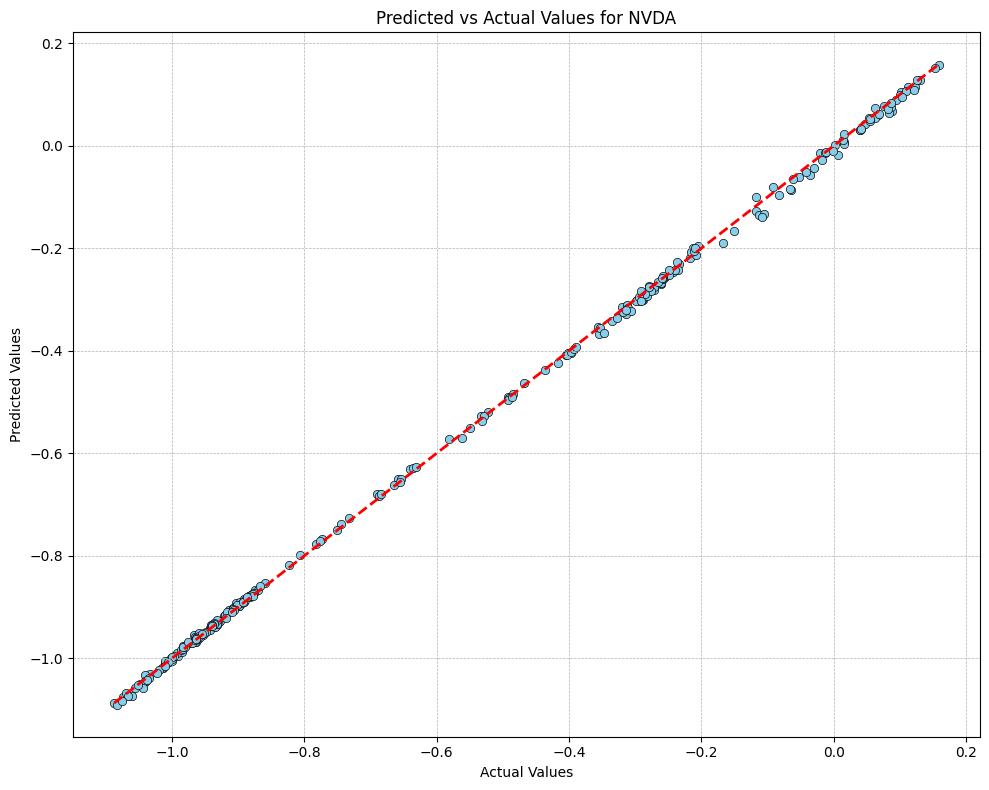

In [10]:

# To start we will need to turn our y_test and y_pred_test into numpy arrays
y_test = np.array(y_test)
y_pred_test = np.array(y_pred_test)

# Now we create the scatterplot
plt.figure(figsize = (10,8))
sns.scatterplot(x = y_test, y = y_pred_test, color = 'skyblue', edgecolor = 'black')

# Next plot the 45-degree line where x = y
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color ='red', linestyle = '--', lw = 2)

# Customize and plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for NVDA')

plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.show()


#### Pretty good for the baseline model!  We will look to improve on this even further later on in the project.  Let's look at a plot that shows the distribution of residuals now.

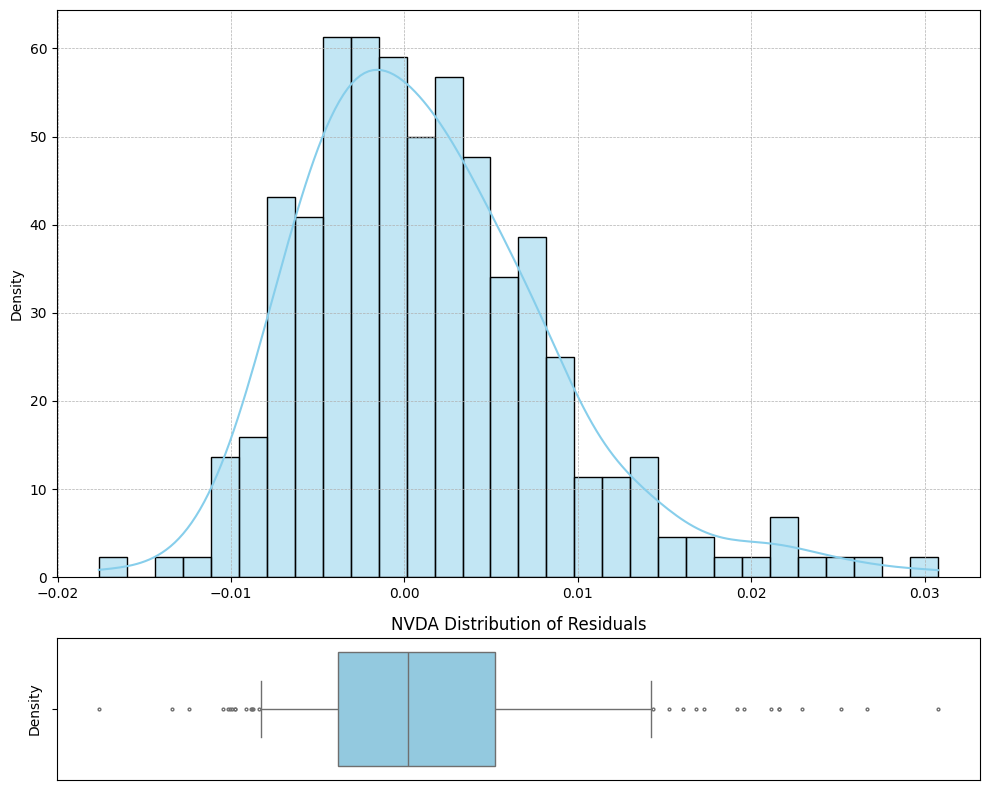

In [11]:
# Calculate the residuals first.
residuals = y_test - y_pred_test

# Create the residuals plot using a combination of matplotlib and seaborn.
fig, (ax_hist, ax_box) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,8),
                                    gridspec_kw = {"height_ratios" : [4,1]})

sns.histplot(residuals, bins = 30, kde = True, stat = 'density', color = 'skyblue', ax = ax_hist)

# Adding the boxplot at the bottom for the marginal distribution
sns.boxplot(x = residuals, ax = ax_box, color = 'skyblue', width = 0.8, whis=[5,95], fliersize = 2)

# Set up titles and labels
plt.title('NVDA Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')

# Customizations to overall plot
ax_box.set_xlabel('')
ax_box.set_xticks([])
ax_box.grid(False)
ax_hist.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.show()




#### In the plot above, the histogram appears relatively symmetric around zero, which suggests that the residuals are normally distributed (or close).  This is what we are looking for because in a proper model residuals should have this normal distribution shape with mean zero.  The boxplot on the bottom portion also confirms that the median residual is very close to zero, indicating that, on average, the model's predictions are not biased in any one direction (over or under-predicting).  The only thing to take note of is the presence of outliers (which were known), as these outliers still do effect the data and look to have caused some predictions to deviate to a significant degree.  It may be worth examining the remainder of these outliers before the advanced modeling stage to see if optimization can occur here.  

## Summary of the Analysis on the NVDA Linear Regression Model

#### In this notebook we developed a baseline Linear Regression model using Ridge and GridSearchCV to predict the closing prices of NVDA stock.  We implemented several of our previous preprocessing steps, including feature creation and scaling as well as outlier detection and removal, followed by model creation and evaluation.  It should also be noted that the model used was the optimized version, as multiple drafts and different options were performed before I landed on a resting spot for this baseline model.  The model shown in this notebook and others in this folder represent the best results from my trial.  It could potentially still be optimized but since this is still considered baseline for our core stock data I will move on with the results yielded here for now.

### Key Insights

#### - The model performed well as a baseline, with a Mean Absolute Error (RMSE) of approximately **$.007** cents and MAPE of **8.3%**.  The R2 and Adjusted R2 both came in at **0.999** as well. 
#### - The residuals analysis indicated that the model's errors are unbiased and normally distributed, suggesting that the model is generally reliable.
#### - The distribution of residuals showed no significant skewness or outliers, further confirming the model's robustness for a baseline.

### Potential Next Steps

#### - In the next phase, we will explore more advanced models such as Decision Trees, GRU, and Transformer models to improve prediction accuracy.
#### - We will also consider incorporating additional data and refining features based on the insights gained from this baseline model.

### Things To Take Note of As We Move Forward

#### - As good as the model performed there still exists the potential to explore outliers in more detail, to optimize these further as they could still be effecting our model results especially when we get into our more advanced models.  It will be worth keeping an eye on and take action on as this project continues.
#### - Currently our data is only lagged out to 3 days, limiting to how far we can forecast.  Should we need to forecast further out we will need to go back and re-lag or extend our lag window (as well as our features) so that our forecast window works appropriately. 